## Goals
In this notebook, you're going to implement a GAN controllability method using gradients from a classifier. By training a classifier to recognize a relevant feature, you can use it to change the generator's inputs (z-vectors) to make it generate images with more or less of that feature.

You will be started you off with a pre-trained generator and classifier, so that you can focus on the controllability aspects. However, in case you would like to train your own classifier, the code for that has been provided as well.

## Learning Objectives
1. Observe how controllability can change a generator's output.
2. Resolve some of the challenges that entangled features pose to controllability.

## TRICKS

### Controlling your GAN |  old noise+ requires_grad_()+classifier[target_indices]+backward() => calculate_updated_noise() => new noise

In [ ]:
#Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_() #z_dim=64

fake = gen(noise)
fake_classes = classifier(fake)[:, 0]


fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)

fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]

assert torch.all(fake_classes_new > fake_classes)

## Generator and Noise

In [ ]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
## Generator and Noise

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Classifier

In [ ]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

In [ ]:
z_dim = 64
batch_size = 128
device = 'cuda'

## Train a Classifier

In [8]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt
   
    # You can run this code to train your own classifier, but there is a provided pretrained one.
    # If you'd like to use this, just run "train_classifier(filename)"
    # to train and save a classifier on the label indices to that filename.

    # Target all the classes, so that's how many the classifier will learn
    # Attributes is 40 (Anno/list_attr_celeba.txt) / vlaue: -1 or 1
    
    label_indices = range(40)
    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            #real: torch.Size([128, 3, 64, 64])
            #labels: tensor([[0, 1, 1,  ..., 1, 0, 1], | torch.Size([128, 40])
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()
            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work in Coursera.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU 
#train_classifier("Test")

## Loading the Pretrained Models
You will then load the pretrained generator and classifier using the following code. (If you trained your own classifier, you can load that one here instead.)

In [9]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Training
Now you can start implementing a method for controlling your GAN!

#### Update Noise
For training, you need to write the code to update the noise to produce more of your desired feature. You do this by performing stochastic gradient ascent. You use stochastic gradient ascent to find the local maxima, as opposed to stochastic gradient descent which finds the local minima. Gradient ascent is gradient descent over the negative of the value being optimized. Their formulas are essentially the same, however, instead of subtracting the weighted value, stochastic gradient ascent adds it; it can be calculated by `new = old + (∇ old * weight)`

You perform stochastic gradient ascent to try and maximize the amount of the feature you want. If you wanted to reduce the amount of the feature, you would perform gradient descent. However, in this assignment you are interested in maximize your feature using gradient ascent, since many features in the dataset are not present much more often than they're present and you are trying to add a feature to the images, not remove.

In [10]:
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''

    new_noise = noise + (noise.grad*weight)
    return new_noise 

In [18]:
# Check that the basic function works
opt.zero_grad()
noise = torch.ones(20, 20) * 2
print('noise:',noise)
noise.requires_grad_() # 0.0100
fake_classes = (noise ** 2).mean()
print(fake_classes)
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1) # 0.0100 * 0.1
print('noise.grad:',noise.grad)
print('new_noise:',new_noise)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

noise: tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2.],
   

In [24]:
#Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_() #z_dim=64
print('old_noise',noise)
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes_a = classifier(fake)[0, 0]
print('fake_classes_a:',fake_classes_a)
print('fake_classes:',fake_classes)
print('fake_classes.mean():',fake_classes.mean())

fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
print('new_noise',noise)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
fake_classes_new_a = classifier(fake)[0, 0]
print('fake_classes_new_a:',fake_classes_new_a)
print('fake_classes_new:',fake_classes_new)
print('fake_classes_new.mean():',fake_classes_new.mean())
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

old_noise tensor([[-0.6473, -2.1060,  0.6210,  ..., -1.4175, -0.7967,  0.3769],
        [ 0.0768, -0.2440, -0.7266,  ..., -0.2872,  0.2824, -1.0410],
        [ 0.0192,  2.0692,  0.2364,  ...,  0.9003,  0.4747,  0.2627],
        ...,
        [-0.4642, -1.4811, -0.6937,  ...,  0.6959, -0.4541,  0.5937],
        [ 0.1817,  1.1566,  0.2775,  ..., -0.3164, -1.2577, -0.8359],
        [ 0.3370,  1.0817, -0.3212,  ...,  0.4028, -0.9126, -0.0345]],
       device='cuda:0', requires_grad=True)
fake_classes_a: tensor(-1.5306, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes: tensor([ -1.5306,  -2.9258,  -9.2460, -11.3272,  -1.5717,  -5.6934,  -1.7676,
         -2.6317,  -6.1976,  -1.8457,  -2.0440,  -9.2617,  -9.1650,  -3.0742,
         -6.7534,  -5.4433,  -6.5031,  -3.7798,  -1.5875,  -5.2360,  -3.5918,
         -3.8607,  -0.1334,  -1.1810,  -3.9007,  -8.4658,  -2.9196,  -9.4910,
         -3.2007,  -2.2589,  -4.9812,  -3.0621], device='cuda:0',
       grad_fn=<SelectBackward>)
fake_classes

#### Generation
Now, you can use the classifier along with stochastic gradient ascent to make noise that generates more of a certain feature. In the code given to you here, you can generate smiling faces. Feel free to change the target index and control some of the other features in the list! You will notice that some features are easier to detect and control than others.

The list you have here are the features labeled in CelebA, which you used to train your classifier. If you wanted to control another feature, you would need to get data that is labeled with that feature and train a classifier on that feature.

target_indices: 31
fake_classes_score_indice: tensor(5.1007, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes_score: tensor(2.5728, device='cuda:0', grad_fn=<MeanBackward0>)
fake_classes_score_indice: tensor(5.3183, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes_score: tensor(3.0856, device='cuda:0', grad_fn=<MeanBackward0>)
fake_classes_score_indice: tensor(5.7803, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes_score: tensor(4.0121, device='cuda:0', grad_fn=<MeanBackward0>)
fake_classes_score_indice: tensor(6.3789, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes_score: tensor(5.1338, device='cuda:0', grad_fn=<MeanBackward0>)
fake_classes_score_indice: tensor(6.8871, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes_score: tensor(6.1693, device='cuda:0', grad_fn=<MeanBackward0>)
fake_classes_score_indice: tensor(7.0263, device='cuda:0', grad_fn=<SelectBackward>)
fake_classes_score: tensor(6.9792, device='cuda:0', grad_fn=<MeanBackward0>)
fake_clas

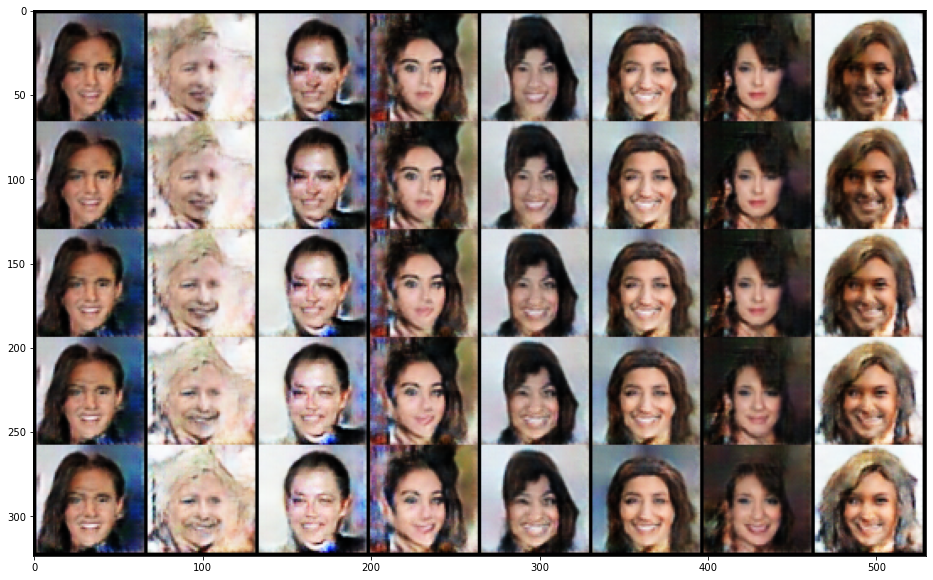

In [21]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names!
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score_ori = classifier(fake)
    fake_classes_score_indice = classifier(fake)[:, target_indices]
    print('fake_classes_score_indice:',classifier(fake)[0, target_indices])
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    print('fake_classes_score:',fake_classes_score)
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)